# Setup

In [ ]:
from google.colab import files                                                                                                                                                                                       
uploaded_1 = files.upload()

Saving sc_cases_cleaned.pkl to sc_cases_cleaned (1).pkl


In [ ]:
uploaded_2 = files.upload()

Saving vocab.pkl to vocab (1).pkl


In [ ]:
import warnings; warnings.simplefilter('ignore')
# set this to your working directory
%matplotlib inline
import pandas as pd
df = pd.read_pickle('sc_cases_cleaned.pkl',compression='gzip')
df=df.reset_index(drop=True)
df = df.assign(author_id=(df['authorship']).astype('category').cat.codes)
df = df[pd.notnull(df['authorship'])] # drop cases without an author
import numpy as np
vocab = pd.read_pickle('vocab.pkl')
from IPython.display import SVG

In [ ]:
df.head()

,case_name,opinion_type,date_standard,authorship,x_republican,maj_judges,dissent_judges,topic_id,cite_count,opinion_text,year,log_cite_count,author_id
0,ERICK CORNELL CLAY v. UNITED STATES,majority,2003-03-04,GINSBURG,0.0,"['BREYER, STEPHEN', 'GINSBURG, RUTH', 'KENNEDY...",[],1.0,2926.0,JUSTICE GINSBURG delivered the opinion of the ...,2003,7.981392,2
1,"HILLSIDE DAIRY INC., A&A DAIRY, L&S DAIRY, AND...",majority,2003-06-09,STEVENS,1.0,"['BREYER, STEPHEN', 'GINSBURG, RUTH', 'KENNEDY...","['THOMAS, CLARENCE']",8.0,117.0,Justice Stevens delivered the opinion of the C...,2003,4.762174,9
2,"CHARLES RUSSELL RHINES v. DOUGLAS WEBER, WARDEN",majority,2005-03-30,O'CONNOR,1.0,"['BREYER, STEPHEN', 'GINSBURG, RUTH', 'KENNEDY...",[],1.0,23364.0,Justice O'Connor delivered the opinion of the ...,2005,10.058952,4
3,STATE OF ALASKA v. UNITED STATES OF AMERICA,majority,2005-06-06,KENNEDY,1.0,"['BREYER, STEPHEN', 'GINSBURG, RUTH', 'KENNEDY...","['REHNQUIST, WILLIAM', 'SCALIA, ANTONIN', 'THO...",10.0,84.0,Justice Kennedy delivered the opinion of the C...,2005,4.430817,3
4,"REGINALD A. WILKINSON, DIRECTOR, OHIO DEPARTME...",majority,2005-06-13,KENNEDY,1.0,"['BREYER, STEPHEN', 'GINSBURG, RUTH', 'KENNEDY...",[],4.0,4230.0,Justice Kennedy delivered the opinion of the C...,2005,8.349957,3


# Entity Embeddings

In [ ]:
# make judge dummy variables
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
J = encoder.fit_transform(df['author_id'].astype(str))
num_judges = max(J)+1
Y = df['x_republican'] > 0
Y2 = df['log_cite_count']

In [ ]:
J[:10]

array([ 3, 10,  5,  4,  4,  9,  1,  3,  2,  3])

In [ ]:
# set up DNN
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

class EmbeddingNet(nn.Module):
  def __init__(self, num_judges):
    super(EmbeddingNet, self).__init__()
    self.embedding = nn.Embedding(num_judges, 2)
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(2, 2)
    self.fc2 = nn.Linear(2, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.embedding(x)
    x = self.flatten(x)
    x = self.fc1(x)
    x = self.fc2(x)
    x = self.sigmoid(x)
    return x


#dot = model_to_dot(model,
#                   show_shapes=True,
#                   show_layer_names=False)
#SVG(dot.create(prog='dot', format='svg'))

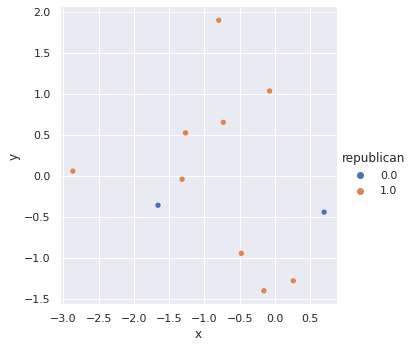

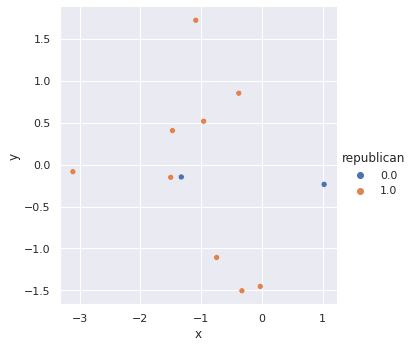

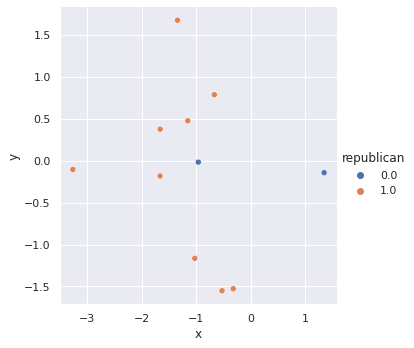

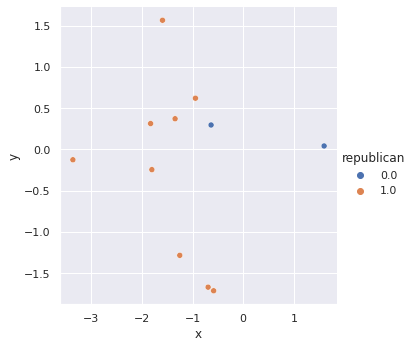

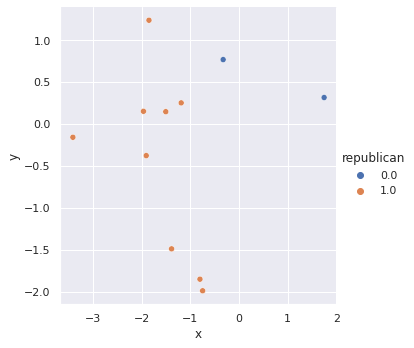

In [ ]:
# Visualize the Judge Vectors
#!pip install ggplot
import seaborn as sns
sns.set_theme()

judge_cites = dict(Y.groupby(J).mean())
df2 = pd.DataFrame(J,columns=['authorship']).drop_duplicates().sort_values('authorship')
df2['republican'] = df2['authorship'].apply(lambda x: judge_cites[x])

class GenericDataset(Dataset):

  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.y)

  def __getitem__(self, index):
    return self.X[index], self.y[index]

model = EmbeddingNet(num_judges)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())

dataset = GenericDataset(J, np.array(Y))
loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

for i in range(5):
  if i > 0:
    for i, (X, label) in enumerate(loader):
      optimizer.zero_grad()
      outputs = model(X)
      loss = criterion(outputs, label.float().unsqueeze(1))
      loss.backward()
      optimizer.step()
  for name, param in model.named_parameters():
    if 'embedding' in name:
      judge_vectors = param.data
  df2['x'] = judge_vectors[:,0]
  df2['y'] = judge_vectors[:,1]    

  sns.relplot( data=df2, x="x", y="y", hue='republican', kind='scatter')


# Word Embeddings

In [ ]:
from gensim.utils import tokenize
from collections import Counter
# keep the most frequent 200 words and convert documents to sequences of word indexes
tokenized_text = [list(tokenize(t, lowercase=True)) for t in df['opinion_text']]
whole_corpus = []
for t in tokenized_text:
  whole_corpus.extend(t)
common_words = set([t[0] for t in Counter(whole_corpus).most_common(200)])
word2id = {w : i + 1 for i, w in enumerate(common_words)}
filtered_sents = [[word2id[w] for w in t if w in common_words] for t in tokenized_text]

In [ ]:
max_len = max([len(t) for t in filtered_sents])

In [ ]:
# represent data as numrows x maxlen matrix
X = np.array([(max_len - len(s)) * [0] + s for s in filtered_sents])
X.shape

(768, 13924)

In [ ]:
X[0]

array([  0,   0,   0, ...,  85,  94, 187])

In [ ]:
X[0][max_len-len(filtered_sents[0]):]

array([133,  79, 171, ...,  85,  94, 187])

In [ ]:
# Model setup

class EmbeddingNet(nn.Module):
  def __init__(self, num_words=200):
    super(EmbeddingNet, self).__init__()
    self.embedding = nn.Embedding(num_words + 1, 2)
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(2 * 13924, 4)
    self.fc2 = nn.Linear(4, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.embedding(x)
    x = self.flatten(x)
    x = self.fc1(x)
    x = self.fc2(x)
    x = self.sigmoid(x)
    return x

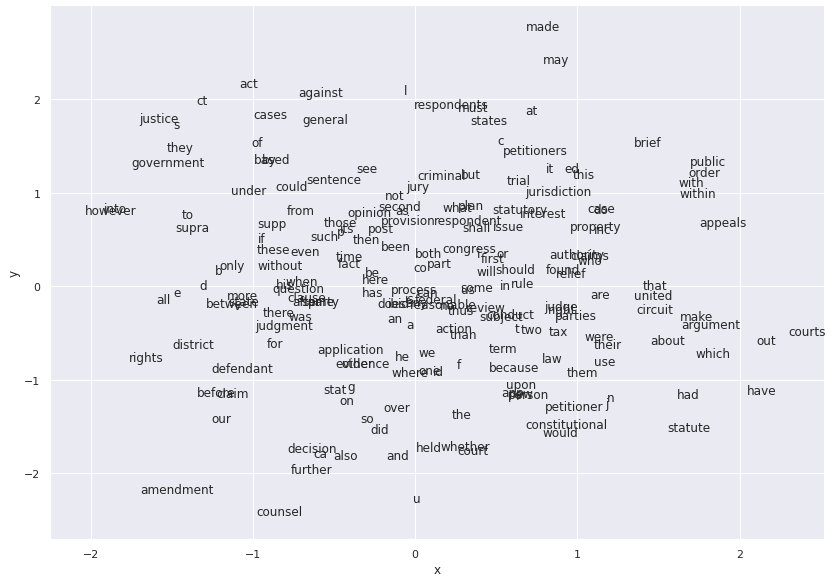

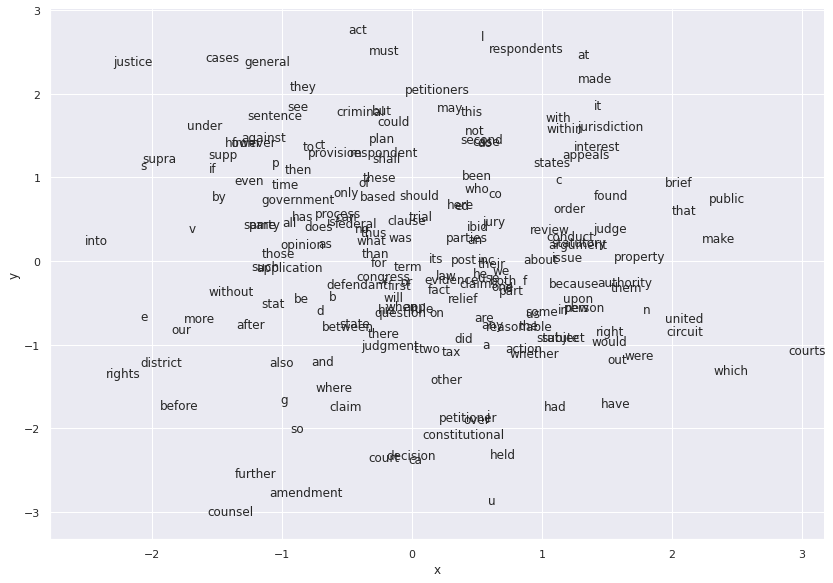

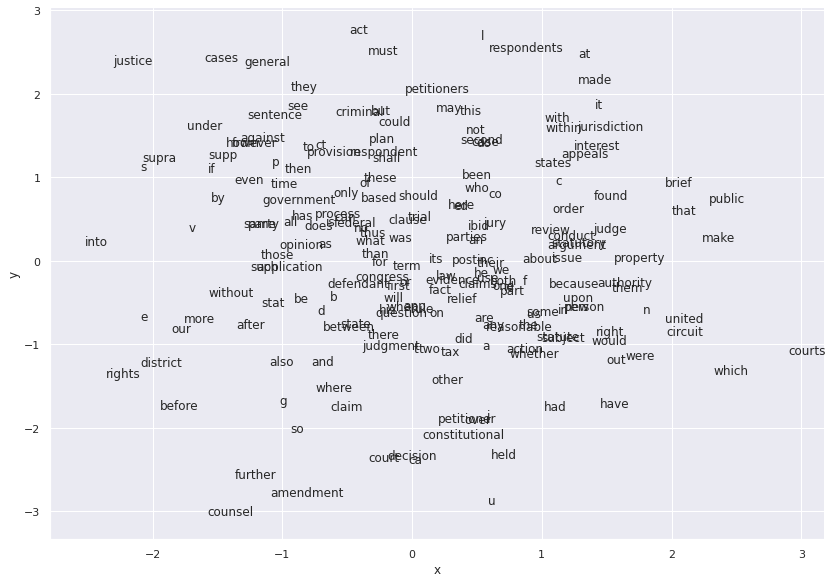

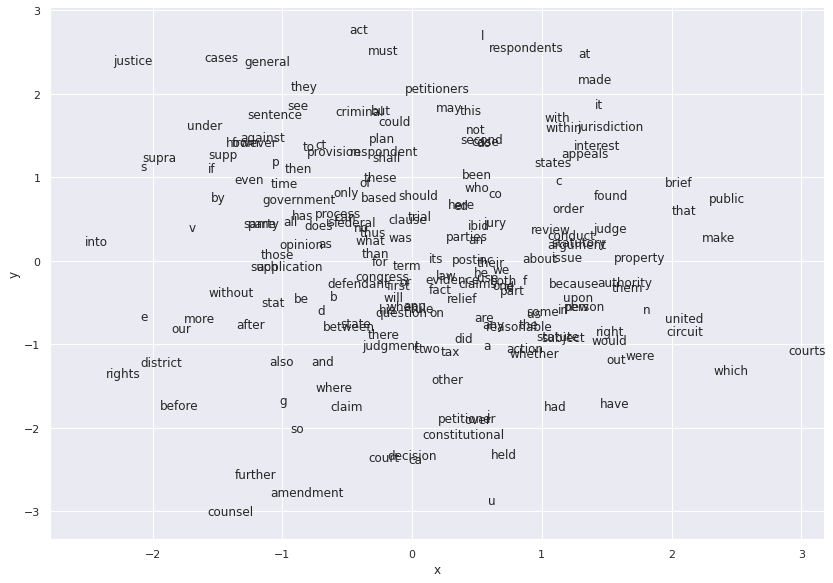

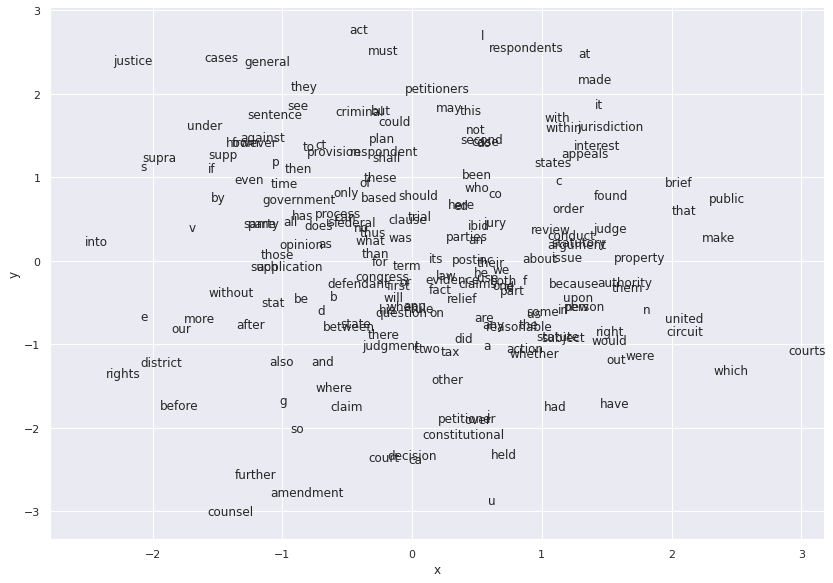

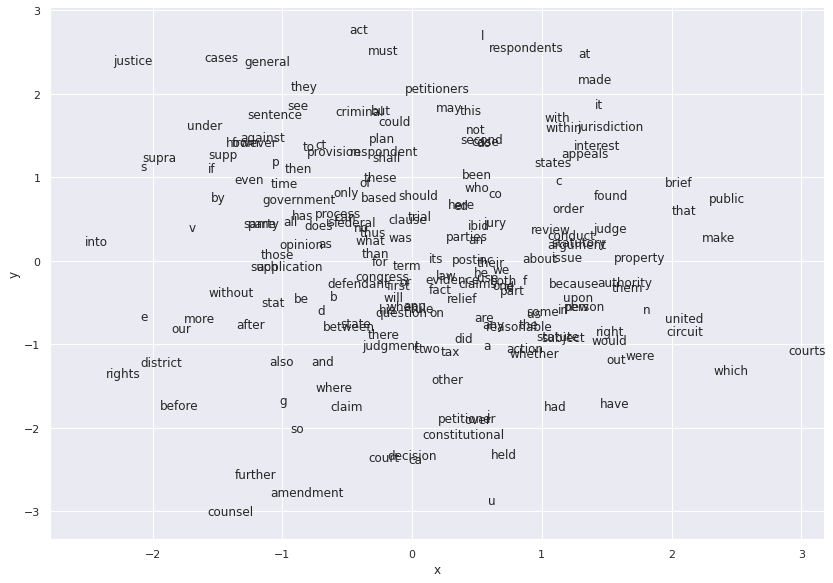

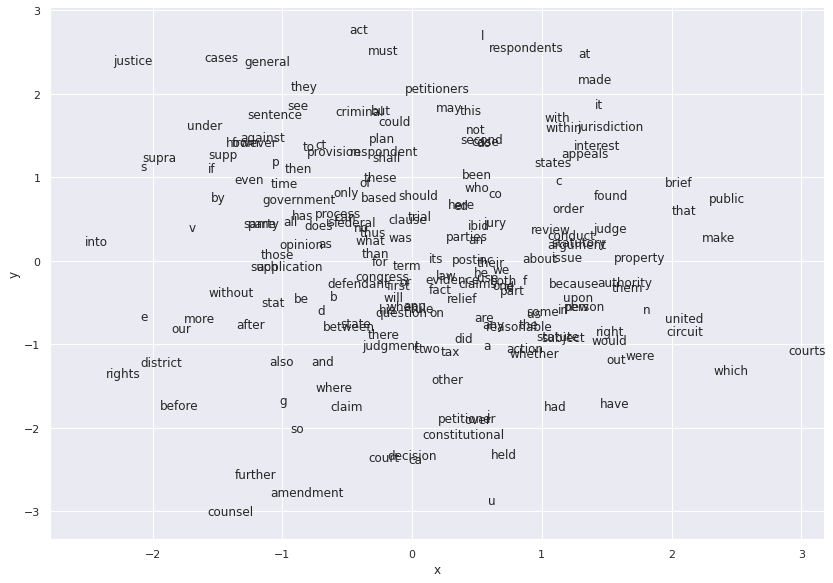

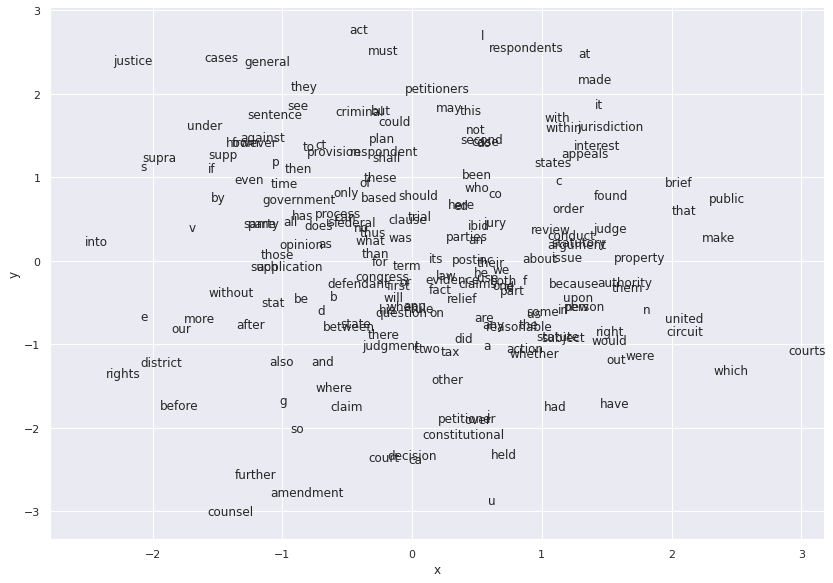

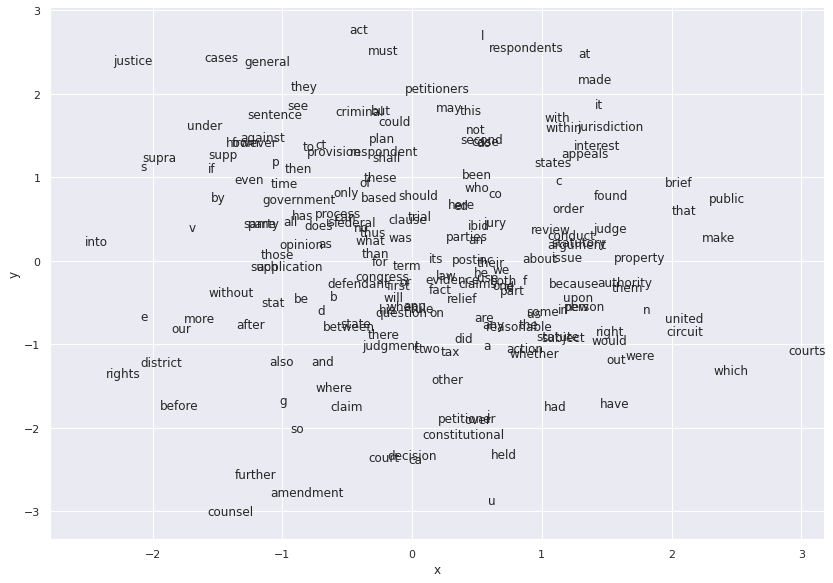

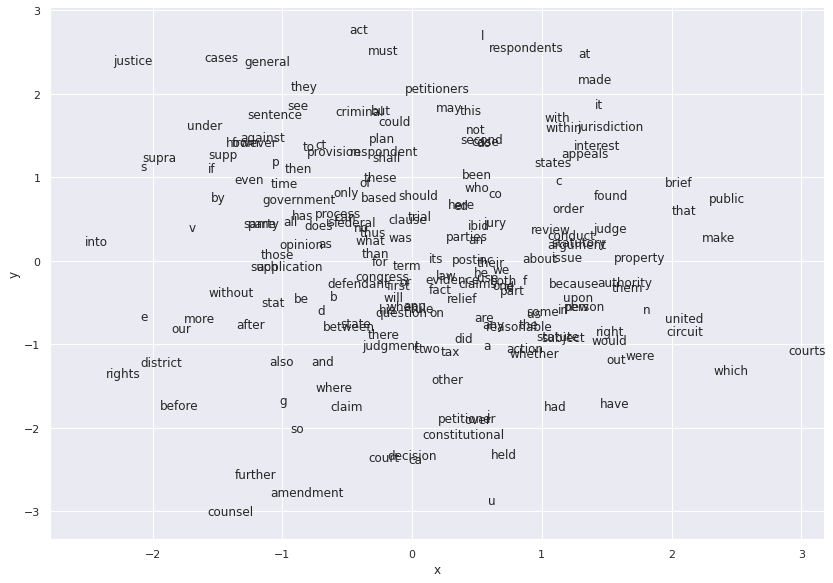

In [ ]:
# show the vectors
from matplotlib import pyplot as plt

num_words = 200
df3 = pd.DataFrame(list(word2id.items()),
                  columns=['word', 'word_index']).sort_values('word_index')[:num_words]

model = EmbeddingNet(num_words)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

dataset = GenericDataset(X, np.array(Y))
loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

for i in range(10):
  if i > 0:
    for data, label in loader:
      optimizer.zero_grad()
      outputs = model(data)
      loss = criterion(outputs, label.float().unsqueeze(1))
      loss.backward()
      optimizer.step()
  for name, param in model.named_parameters():
    if 'embedding' in name:
      word_vectors = param.data
  df3['x'] = word_vectors[1:,0]
  df3['y'] = word_vectors[1:,1]


  plot = sns.relplot( data=df3, x="x", y="y", s=0, height=8.27, aspect=11.7/8.27)

  for row in df3.itertuples():
      ax = plot.axes[0, 0]
      ax.text(row.x, row.y, row.word, horizontalalignment='left')
  plt.show()


In [ ]:
# Word Similarity
from scipy.spatial.distance import cosine

vec_defendants = word_vectors[word2id['defendant']+1]
vec_sent = word_vectors[word2id['sentence']+1]
vec_against = word_vectors[word2id['against']+1]

print(1-cosine(vec_defendants, vec_sent))

0.6167880892753601


In [ ]:
print(1-cosine(vec_defendants, vec_against))

0.2602670192718506


# Word2Vec in gensim

In [ ]:
# word2vec requires sentences as input
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk import sent_tokenize
from string import punctuation
translator = str.maketrans('','',punctuation) 
from nltk.corpus import stopwords
stoplist = set(stopwords.words('english'))
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('english')

def normalize_text(doc):
    "Input doc and return clean list of tokens"
    doc = doc.replace('\r', ' ').replace('\n', ' ')
    lower = doc.lower() # all lower case
    nopunc = lower.translate(translator) # remove punctuation
    words = nopunc.split() # split into tokens
    nostop = [w for w in words if w not in stoplist] # remove stopwords
    no_numbers = [w if not w.isdigit() else '#' for w in nostop] # normalize numbers
    stemmed = [stemmer.stem(w) for w in no_numbers] # stem each word
    return stemmed

def get_sentences(doc):
    sent=[]
    for raw in sent_tokenize(doc):
        raw2 = normalize_text(raw)
        sent.append(raw2)
    return sent

sentences = []
for doc in df['opinion_text']:
    sentences += get_sentences(doc)
from random import shuffle
shuffle(sentences) # stream in sentences in random order

# train the model
from gensim.models import Word2Vec
w2v = Word2Vec(sentences,  # list of tokenized sentences
               workers = 8, # Number of threads to run in parallel
               vector_size=300,  # Word vector dimensionality     
               min_count =  25, # Minimum word count  
               window = 5, # Context window size      
               sample = 1e-3, # Downsample setting for frequent words
               )

# done training, so delete context vectors
w2v.init_sims(replace=True)

w2v.save('w2v-vectors.pkl')

w2v.wv['judg'] # vector for "judge"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


array([-0.05993904,  0.05159581,  0.00454926, -0.0111529 ,  0.01867774,
       -0.02984256, -0.05670498, -0.04440458, -0.01682346, -0.03532658,
        0.11195984, -0.00938346,  0.02418771, -0.09470788,  0.01136989,
       -0.04576194,  0.0468153 ,  0.02129278, -0.08395679,  0.09637607,
        0.07516148, -0.03031379,  0.05235882, -0.0165687 , -0.0871476 ,
       -0.04413121, -0.00618426,  0.03797666,  0.05608553,  0.08647915,
        0.01794385,  0.00192495, -0.04514125,  0.04365997,  0.01296155,
        0.04136496,  0.0267633 , -0.00639733, -0.00634731, -0.01951245,
        0.11082517,  0.0234804 ,  0.01252621, -0.04693402,  0.02554968,
       -0.01860922, -0.0015363 , -0.00589627, -0.08364441, -0.02544704,
        0.06286498, -0.05770473, -0.05856584, -0.0807896 , -0.01460237,
       -0.09222618, -0.00570577,  0.09383096,  0.05957523, -0.04446601,
       -0.10558207,  0.0335613 ,  0.04474504, -0.07040609,  0.05005265,
       -0.06765911,  0.0212102 ,  0.04143804, -0.00082309, -0.12

In [ ]:
w2v.wv.similarity('judg','juri') # similarity 

0.57158613

In [ ]:
w2v.wv.most_similar('judg') # most similar words

[('bench', 0.5953693389892578),
 ('juri', 0.5715861320495605),
 ('magistr', 0.5351980328559875),
 ('panel', 0.5351102352142334),
 ('court', 0.533636212348938),
 ('factfind', 0.5213727355003357),
 ('speedi', 0.5193161964416504),
 ('imparti', 0.5167227387428284),
 ('special', 0.4996529221534729),
 ('prosecutor', 0.49743568897247314)]

In [ ]:
# word2vec requires sentences as input
from nltk import sent_tokenize
from string import punctuation
translator = str.maketrans('','',punctuation) 
from nltk.corpus import stopwords
stoplist = set(stopwords.words('english'))
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('english')

def normalize_text(doc):
    "Input doc and return clean list of tokens"
    doc = doc.replace('\r', ' ').replace('\n', ' ')
    lower = doc.lower() # all lower case
    nopunc = lower#.translate(translator) # remove punctuation
    words = nopunc.split() # split into tokens
    nostop = [w for w in words ]#if w not in stoplist] # remove stopwords
    no_numbers = [w if not w.isdigit() else '#' for w in nostop] # normalize numbers
    stemmed = [stemmer.stem(w) for w in no_numbers] # stem each word
    return stemmed

def get_sentences(doc):
    sent=[]
    for raw in sent_tokenize(doc):
        raw2 = normalize_text(raw)
        sent.append(raw2)
    return sent

sentences = []
for doc in df['opinion_text']:
    sentences += get_sentences(doc)
from random import shuffle
shuffle(sentences) # stream in sentences in random order

# train the model
from gensim.models import Word2Vec
w2v = Word2Vec(sentences,  # list of tokenized sentences
               workers = 8, # Number of threads to run in parallel
               size=300,  # Word vector dimensionality     
               min_count =  25, # Minimum word count  
               window = 5, # Context window size      
               sample = 1e-3, # Downsample setting for frequent words
               )

# done training, so delete context vectors
w2v.init_sims(replace=True)

w2v.save('w2v-vectors.pkl')

w2v.wv['judg'] # vector for "judge"

array([ 0.02851629, -0.07923002, -0.00551179,  0.0383895 , -0.07205567,
       -0.01206726,  0.04564866, -0.00605167, -0.01043567, -0.01504642,
       -0.00983567, -0.04574488,  0.04552822, -0.15329002, -0.02193193,
       -0.12876393,  0.15120699, -0.06422534, -0.05565018, -0.03013898,
        0.09613314,  0.00678954,  0.02318116,  0.07089709, -0.04036016,
        0.07273384,  0.08443981,  0.02420141,  0.0626275 ,  0.03980436,
        0.0383553 ,  0.02891082,  0.01637372,  0.08545417, -0.05382832,
       -0.08237512,  0.00599404,  0.02509696,  0.00212319,  0.07038054,
       -0.02002814, -0.01676246, -0.02776926, -0.09583973,  0.06601088,
       -0.04045736, -0.05706986,  0.0018374 ,  0.06114435, -0.08134822,
       -0.05433097,  0.03152781, -0.15251632,  0.03546267, -0.00323954,
        0.00208544, -0.07791933,  0.00187374, -0.05247102,  0.03435352,
       -0.04539087,  0.06423523, -0.04655546, -0.00838754,  0.01257413,
       -0.01209248,  0.00452459, -0.06278877,  0.04203266, -0.07

In [ ]:
w2v.wv.similarity('judg','juri') # similarity 

0.5465266

In [ ]:
w2v.wv.most_similar('judg') # most similar words

[('bench', 0.6013386845588684),
 ('juri', 0.5465266108512878),
 ('court', 0.5431677103042603),
 ('imparti', 0.5357877016067505),
 ('panel', 0.526603102684021),
 ('factfind', 0.5262992978096008),
 ('prosecutor', 0.5142860412597656),
 ('speedi', 0.49852198362350464),
 ('unanim', 0.49445295333862305),
 ('special', 0.49335604906082153)]

In [ ]:
# analogies: judge is to man as __ is to woman
w2v.wv.most_similar(positive=['judg','man'],
                 negative=['woman'])

[('bench', 0.5549931526184082),
 ('panel', 0.5038875341415405),
 ('magistr', 0.4887916147708893),
 ('sit', 0.4718834161758423),
 ('prosecutor', 0.4704435467720032),
 ('court', 0.4483681321144104),
 ('unanim', 0.43796804547309875),
 ('imparti', 0.43094074726104736),
 ('juri', 0.42551714181900024),
 ('brillon', 0.4082872271537781)]

In [ ]:
# Word2Vec: K-Means Clusters
from sklearn.cluster import KMeans
kmw = KMeans(n_clusters=50)
kmw.fit(w2v.wv.vectors)
judge_clust = kmw.labels_[w2v.wv.key_to_index['judg']]
for i, cluster in enumerate(kmw.labels_):
    if cluster == judge_clust and i<=100:
        print(w2v.wv.index_to_key[i])

court
case
district
appeal
also
question
issu
decis
first
review
held
circuit
hold
judg


# Pre-trained vectors

In [ ]:
import spacy
en = spacy.load('en_core_web_sm')
apple = en('apple') 
apple.vector # vector for 'apple'

array([-1.2599487 , -0.87038326, -1.0834986 ,  0.5798379 ,  0.03857595,
       -0.02588724,  0.9775548 ,  0.31093895,  0.19412561, -0.8062178 ,
        0.43808204, -1.8498268 , -0.30574286,  0.5693637 ,  0.42844394,
        0.69174224, -0.7197368 , -1.2614795 ,  0.83457553,  0.14667332,
        0.12171662,  0.48029226,  0.50147873, -0.4299112 ,  0.5533447 ,
        0.8749714 ,  0.71914   ,  0.5731143 , -0.5064311 ,  0.38493997,
       -0.31778833,  0.18084693,  0.5162936 , -0.00233826,  0.1870515 ,
       -1.3773322 ,  1.009095  , -0.10771251,  1.6994228 ,  0.78603184,
       -0.8166558 ,  0.57896584, -0.5232718 ,  0.7045958 , -0.46308953,
       -0.37629813, -0.38788998,  0.1730735 , -0.05550597, -0.17245518,
        0.62919456,  0.87473   ,  0.60047954, -0.27686393,  0.8524152 ,
       -0.28676936,  0.9972549 , -0.71060055,  0.11830124, -0.37214422,
       -1.3039289 , -0.02281845,  0.4063236 , -0.43118405,  0.9401908 ,
       -0.02761412, -0.39026427, -0.29733896,  0.78710043, -0.34

In [ ]:
apple.similarity(apple)

1.0

In [ ]:
orange = en('orange')
apple.similarity(orange)

0.35815910581210864

In [ ]:
import spacy
# !python -m spacy download de_core_news_sm
de = spacy.load('de_core_news_sm')
apfel = de('apfel')
orange = de('orange')
apfel.similarity(orange)

0.37115291343357987

In [ ]:
# Initializing an embedding layer with pre-trained vectors
embed_dims = len(apple.vector)
embedding_matrix = np.zeros([num_words, embed_dims])
for word, i in word2id.items():
    if i > num_words:
        break
    embedding_vector = en(word).vector
    embedding_matrix[i-1] = embedding_vector    

In [ ]:
class EmbeddingNet(nn.Module):
  def __init__(self, num_words=200):
    super(EmbeddingNet, self).__init__()
    self.embedding = nn.Embedding(num_words + 1, 96)
    with torch.no_grad():
      self.embedding.weight[1:, :] = torch.nn.Parameter(torch.from_numpy(embedding_vector))
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(96 * 13924, 64)
    self.relu1 = nn.ReLU()
    self.fc2 = nn.Linear(64, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.embedding(x)
    x = self.flatten(x)
    x = self.fc1(x)
    x = self.relu1(x)
    x = self.fc2(x)
    x = self.sigmoid(x)
    return x


[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 201 samples in 0.000s...
[t-SNE] Computed neighbors for 201 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 201 / 201
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.063560
[t-SNE] KL divergence after 300 iterations: 0.024077


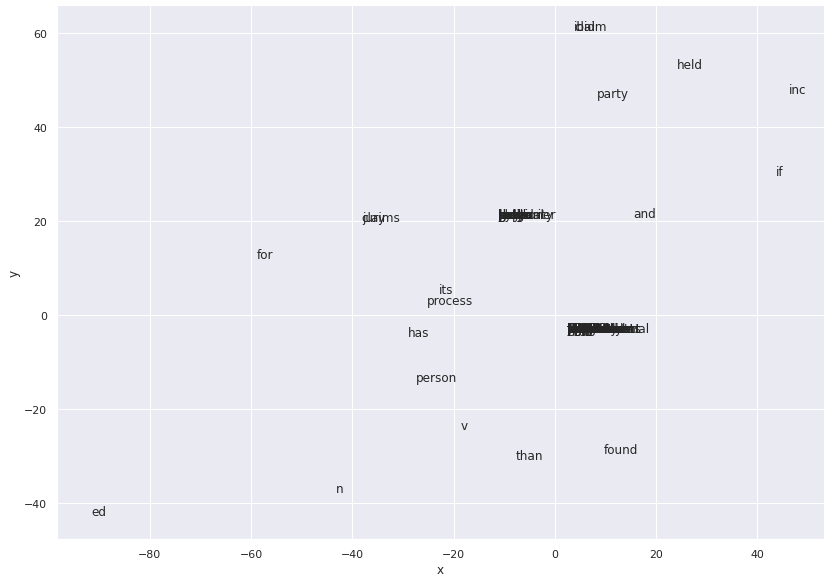

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 201 samples in 0.001s...
[t-SNE] Computed neighbors for 201 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 201 / 201
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.656967
[t-SNE] KL divergence after 300 iterations: 1.705258


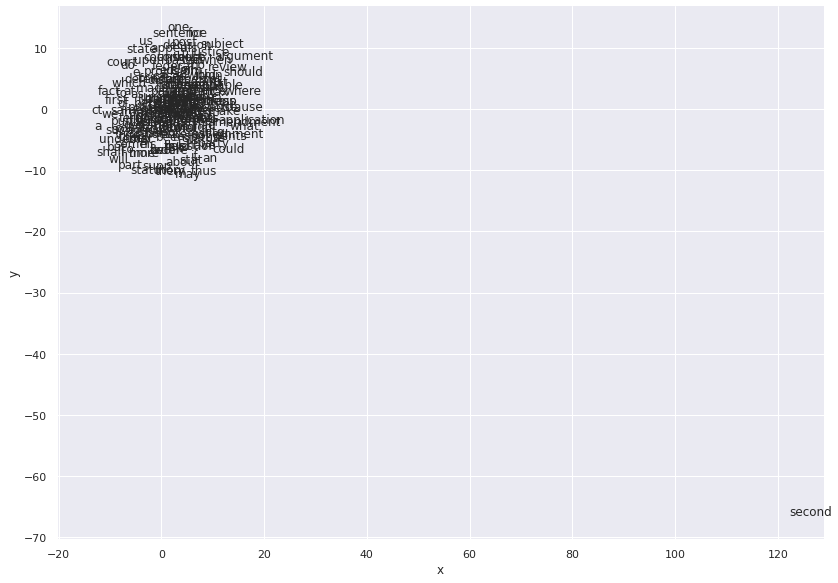

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 201 samples in 0.000s...
[t-SNE] Computed neighbors for 201 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 201 / 201
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.116486
[t-SNE] KL divergence after 300 iterations: 1.367690


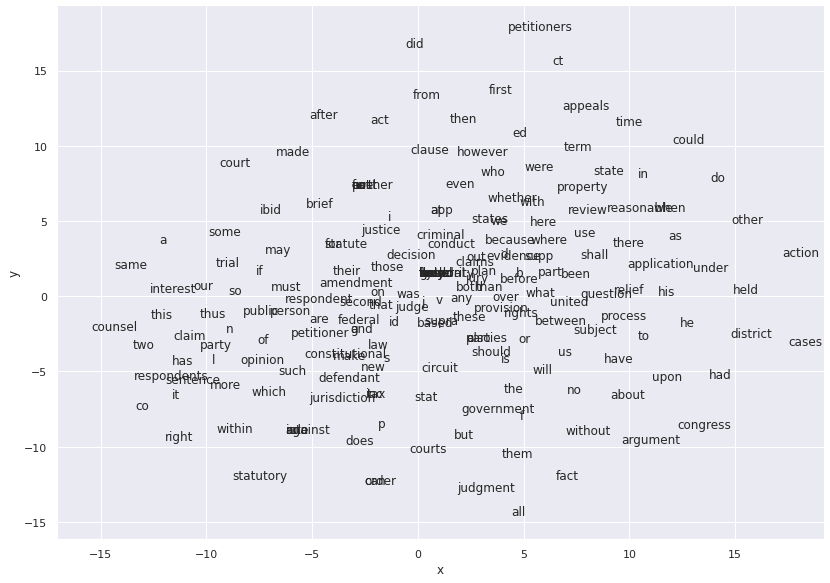

In [ ]:
# show the vectors
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=300)

df3 = pd.DataFrame(list(word2id.items()),
                  columns=['word', 'word_index']).sort_values('word_index')[:num_words]
model = EmbeddingNet()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

dataset = GenericDataset(X, np.array(Y))
loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)
for i in range(3):
  if i > 0:
    for data, label in loader:
      optimizer.zero_grad()
      outputs = model(data)
      loss = criterion(outputs, label.float().unsqueeze(1))
      loss.backward()
      optimizer.step()
  for name, param in model.named_parameters():
    if 'embedding' in name:
      word_vectors = param.data
  wv_tsne = tsne.fit_transform(word_vectors)
  df3['x'] = wv_tsne[1:,0]
  df3['y'] = wv_tsne[1:,1]
  plot = sns.relplot( data=df3, x="x", y="y", s=0, height=8.27, aspect=11.7/8.27)

  for row in df3.itertuples():
      ax = plot.axes[0, 0]
      ax.text(row.x, row.y, row.word, horizontalalignment='left')
  plt.show()

# Fast Text
See more at https://github.com/facebookresearch/fastText#example-use-cases

In [ ]:
!pip install fasttext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import fasttext

with open('data.txt', 'w') as f:
  for i, t in enumerate(df['opinion_text']):
    f.write(t + '\n')
    if i > 5:
      break
# train a Skipgram model :
model = fasttext.train_unsupervised('data.txt', model='skipgram')

In [ ]:
model.words[:100]

['the',
 'of',
 'to',
 '</s>',
 'and',
 'a',
 'in',
 'that',
 'for',
 'is',
 'at',
 '§',
 'as',
 'not',
 'L.',
 'Ed.',
 'S.',
 'Ct.',
 'or',
 'The',
 'v.',
 '2d',
 'by',
 'United',
 'be',
 'an',
 'this',
 'it',
 'with',
 'on',
 'U.S.',
 'States',
 'Alaska',
 'we',
 'have',
 'from',
 'its',
 '.',
 'Court',
 'would',
 'federal',
 'See',
 'In',
 'which',
 'was',
 'waters',
 'any',
 'such',
 'are',
 'under',
 'court',
 'has',
 'F.3d',
 'District',
 'submerged',
 'Id.,',
 "Alaska's",
 'Glacier',
 'his',
 'We',
 'lands',
 'Special',
 'Act',
 'but',
 'also',
 'state',
 'no',
 'one',
 'within',
 'Bay',
 'may',
 'other',
 'FCC',
 'had',
 'these',
 'must',
 'all',
 'title',
 'does',
 'U.S.C.',
 'Master',
 'only',
 'when',
 'supra,',
 'cause',
 'Alexander',
 'before',
 'so',
 'their',
 'interest',
 'claim',
 'petition',
 'set',
 'inland',
 'if',
 'than',
 'were',
 'State',
 'carrier',
 'National']

In [ ]:
model['state']

array([ 0.36663407,  0.09105047, -0.0039585 , -0.09754987, -0.02831085,
        0.23822504,  0.17059796,  0.05757025, -0.1848151 , -0.07677744,
       -0.01095056,  0.06835422, -0.10534765,  0.17091899, -0.12048642,
        0.05021045, -0.12728262, -0.14272103, -0.08261074, -0.10307318,
        0.08069936,  0.22604047,  0.00552835,  0.14294727, -0.07476959,
       -0.09731885, -0.05230441,  0.10619038, -0.31311572, -0.03565533,
       -0.00570739,  0.16563591,  0.01932826, -0.27892137, -0.09742418,
        0.0805367 ,  0.0285652 ,  0.19195075, -0.27342123, -0.04479552,
       -0.0505508 ,  0.15632743,  0.18391351,  0.08457699,  0.2410913 ,
       -0.23703487,  0.04118426, -0.093353  , -0.12564546,  0.05929349,
       -0.1471216 , -0.03879624, -0.22491565,  0.04537795, -0.05979959,
       -0.10096239, -0.11494176, -0.084983  , -0.06227178,  0.05589023,
       -0.02769869,  0.13424939,  0.2392042 ,  0.30455408,  0.3733109 ,
       -0.07445237,  0.03493206, -0.09445407, -0.108128  , -0.01

# Embedding Lookup

Keras provides functionality to feed just words (actually indices of words) as model input. The model then performs an embedding lookup (we go from sparse one-hot to dense) which then becomes the input for further computation in the model. For a more detailed tutorial, have a look [here](https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/). 

First, we have to pre-process the data once again

In [ ]:
#df['opinion_text']

from keras.preprocessing.text import text_to_word_sequence

# tokenize the text


tokenized = [text_to_word_sequence(opinion) for opinion in df["opinion_text"]]
print (tokenized[0][:50])

['justice', 'ginsburg', 'delivered', 'the', 'opinion', 'of', 'the', 'court', 'a', 'motion', 'by', 'a', 'federal', 'prisoner', 'for', 'postconviction', 'relief', 'under', '28', 'u', 's', 'c', '§', '2255', 'is', 'subject', 'to', 'a', 'one', 'year', 'time', 'limitation', 'that', 'generally', 'runs', 'from', 'the', 'date', 'on', 'which', 'the', 'judgment', 'of', 'conviction', 'becomes', 'final', '§', '2255', 'p6', '1']


In [ ]:
from collections import Counter
counter = Counter()
for i in tokenized:
        counter.update(i)
print (counter.most_common(10))
num_words = len(counter)
print (num_words) ## 58'787
print (max(len(i) for i in tokenized)) # 26'097, this is one of the challenges of working with legal text

[('the', 268092), ('of', 135373), ('to', 107507), ('a', 87432), ('that', 75017), ('in', 72525), ('and', 65488), ('s', 50775), ('at', 40610), ('for', 37386)]
58787
26097


In [ ]:
# create one_hot representation for each word
!pip install Keras-Preprocessing
from keras.preprocessing.text import one_hot
from keras_preprocessing.sequence import pad_sequences
length_vocab = 10000
X_one_hot = [one_hot(opinion, n=length_vocab) for opinion in df["opinion_text"]]
print (X_one_hot[0][:50])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 4.7 MB/s eta 0:00:00
[3515, 5215, 1156, 9557, 4288, 9330, 9557, 8807, 2544, 9495, 7750, 2544, 34, 8976, 4774, 9589, 3013, 3643, 5809, 1373, 2713, 1479, 9197, 2251, 22, 9059, 5302, 2544, 8427, 6908, 1702, 44, 4322, 192, 4607, 1480, 9557, 8870, 6777, 2723, 9557, 8981, 9330, 1395, 784, 7153, 9197, 2251, 8166, 3833]


In [ ]:
# next, we pad (or truncate) such that all the inputs have same length

max_seq_length = 2000
X_one_hot_padded = pad_sequences(X_one_hot, padding='post', maxlen=max_seq_length, truncating='post')
X_one_hot_padded.shape # (768, 2000)

(768, 2000)

**Embedding lookup**

In [ ]:
from keras.layers import Embedding
from keras.models import Sequential

model = Sequential() # create a sequential model
model.add(Embedding(length_vocab, 64, input_length=max_seq_length, name="embedding_layer"))
model.summary() #640'000 params because 64 dim for 10'000 words

# that's it


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_layer (Embedding)  (None, 2000, 64)         640000    
                                                                 
Total params: 640,000
Trainable params: 640,000
Non-trainable params: 0
_________________________________________________________________


# GloVe

In [ ]:
!pip install glove-python-binary 
#!pip install glove_python for other versions

import itertools
from glove import Corpus, Glove

from nltk import sent_tokenize
from string import punctuation
translator = str.maketrans('','',punctuation) 
from nltk.corpus import stopwords
stoplist = set(stopwords.words('english'))
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('english')

def normalize_text(doc):
    "Input doc and return clean list of tokens"
    doc = doc.replace('\r', ' ').replace('\n', ' ')
    lower = doc.lower() # all lower case
    nopunc = lower.translate(translator) # remove punctuation
    words = nopunc.split() # split into tokens
    nostop = [w for w in words if w not in stoplist] # remove stopwords
    no_numbers = [w if not w.isdigit() else '#' for w in nostop] # normalize numbers
    stemmed = [stemmer.stem(w) for w in no_numbers] # stem each word
    return stemmed

def get_sentences(doc):
    sent=[]
    for raw in sent_tokenize(doc):
        raw2 = normalize_text(raw)
        sent.append(raw2)
    return sent

sentences = []
for doc in df['opinion_text']:
    sentences += get_sentences(doc)
from random import shuffle
shuffle(sentences) # stream in sentences in random order

corpus = Corpus()
corpus.fit(sentences, window=10)
glove = Glove(no_components=100, learning_rate=0.05)

In [ ]:
glove.fit(corpus.matrix, epochs=30, no_threads=4, verbose=True)
glove.add_dictionary(corpus.dictionary)

In [ ]:
glove.word_vectors[glove.dictionary['judg']]

In [ ]:
glove.most_similar('judg')


# Word Mover Distance

Word Mover’s Distance (WMD) is a promising tool (based on word2vec) in machine learning that allows us to submit a query and return the most relevant documents. The intuition behind the method is that we find the minimum “traveling distance” between documents, in other words the most efficient way to “move” the distribution of document 1 to the distribution of document 2.

In [1]:
sentence_obama = 'Obama speaks to the media in Illinois'
sentence_president = 'The president greets the press in Chicago'

In [2]:
# Import and download stopwords from NLTK.
from nltk.corpus import stopwords
from nltk import download
download('stopwords')  # Download stopwords list.
stop_words = stopwords.words('english')

def preprocess(sentence):
    return [w for w in sentence.lower().split() if w not in stop_words]

sentence_obama = preprocess(sentence_obama)
sentence_president = preprocess(sentence_president)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
import gensim.downloader as api
model = api.load('word2vec-google-news-300')

[=================================================-] 99.8% 1660.0/1662.8MB downloaded


In [11]:
#!pip install POT
distance = model.wmdistance(sentence_obama, sentence_president)
print('distance = %.4f' % distance)

distance = 1.0175


In [12]:
sentence_orange = preprocess('Oranges are my favorite fruit')
distance = model.wmdistance(sentence_obama, sentence_orange)
print('distance = %.4f' % distance)

distance = 1.3664
